In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import mixed_precision #increase processing speed
mixed_precision.set_global_policy('mixed_float16')

C:\Users\snetkova\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\snetkova\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\snetkova\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1650, compute capability 7.5


#### load data

In [2]:
# tfds.disable_progress_bar()
(train_dataset, validation_dataset, test_dataset), ds_info = tfds.load(
    'food101', 
    as_supervised=True,
    with_info=True,
    split=['train[:]', 'validation[:80%]', 'validation[80%:]'],
)

In [3]:
print('train shape:', tf.data.experimental.cardinality(train_dataset).numpy())
print('valid shape:', tf.data.experimental.cardinality(validation_dataset).numpy())
print('test shape:', tf.data.experimental.cardinality(test_dataset).numpy())

train shape: 75750
valid shape: 20200
test shape: 5050


#### show data

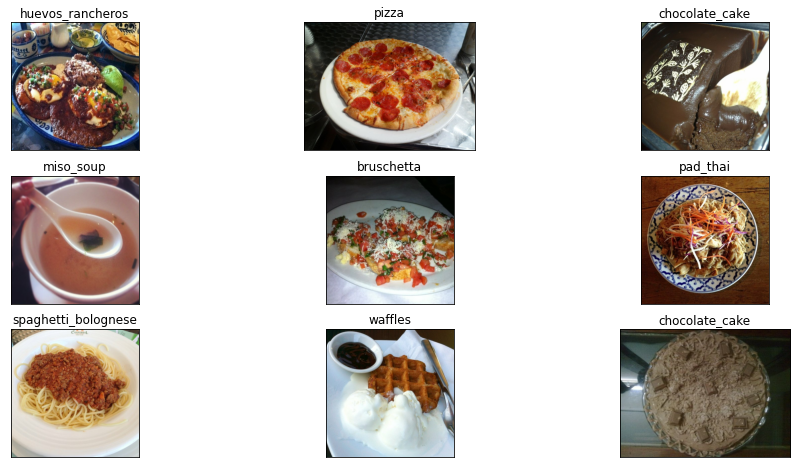

In [4]:
class_names = ds_info.features['label'].names

some_samples = [x[0] for x in iter(train_dataset.take(9))]
some_labels = [x[1] for x in iter(train_dataset.take(9))]

fig = plt.figure(figsize=(16, 8))
for j in range(len(some_samples)):
    ax = fig.add_subplot(3, 3, j+1)
    ax.imshow(some_samples[j])
    plt.title(class_names[some_labels[j].numpy()])
    plt.xticks([]), plt.yticks([])
plt.show()

#### data augmentation

In [5]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

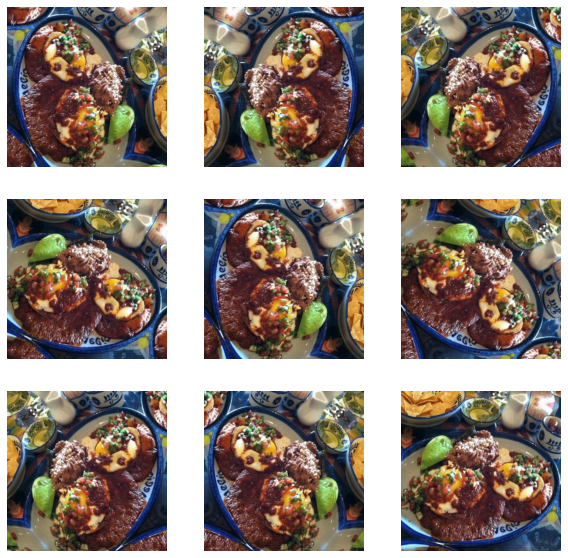

In [6]:
first_image = [x[0] for x in iter(train_dataset.take(1))][0]
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

#### preprocess data

In [7]:
INP_SIZE = 160
NUM_EPOCHS = 3
BATCH_SIZE = 32

def prepare(img, label):
    img = tf.cast(img, tf.float32)/127. - 1.
    return tf.image.resize(img, (INP_SIZE, INP_SIZE)), label

train_dataset = train_dataset.shuffle(buffer_size=1000)
train_dataset = train_dataset.map(prepare)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

validation_dataset = validation_dataset.shuffle(buffer_size=1000)
validation_dataset = validation_dataset.map(prepare)
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=True)

# test_dataset = test_dataset.shuffle(buffer_size=1000)
test_dataset = test_dataset.map(prepare)
test_dataset = test_dataset.batch(128, drop_remainder=True)

#### model

In [8]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(INP_SIZE, INP_SIZE, 3),
                                               include_top=False,
                                               weights='imagenet')

In [9]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [10]:
# model = tf.keras.Sequential([
#     base_model,
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(101, activation='softmax'),
# ])

In [11]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(101)(x)
outputs = tf.keras.layers.Activation(activation="softmax", dtype=tf.float32)(x)
model = tf.keras.Model(inputs, outputs)

In [12]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

def tensorboard_callback(directory, name):
    log_dir = directory + "/" + name
    t_c = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
    return t_c

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
activation (Activation)      (None, 101)               0         
Total params: 2,387,365
Trainable params: 2,353,253
Non-trainable params: 34,112
______________________________________________

In [14]:
%%time
with tf.device('/device:GPU:0'):
    history = model.fit(
        train_dataset,
        epochs=NUM_EPOCHS,
        validation_data=validation_dataset,
        callbacks=[tensorboard_callback("Tensorboard","model")]
    )

Epoch 1/3

C:\Users\snetkova\Anaconda3\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)



2367/2367 [==============================] - 693s 289ms/step - loss: 2.8494 - accuracy: 0.3197 - val_loss: 2.0577 - val_accuracy: 0.4720
Epoch 2/3
2367/2367 [==============================] - 687s 290ms/step - loss: 1.7801 - accuracy: 0.5408 - val_loss: 1.5757 - val_accuracy: 0.5796
Epoch 3/3
2367/2367 [==============================] - 690s 291ms/step - loss: 1.5259 - accuracy: 0.5998 - val_loss: 1.6782 - val_accuracy: 0.5582
Wall time: 34min 30s


In [15]:
model.evaluate(validation_dataset)

631/631 [==============================] - 52s 82ms/step - loss: 1.6784 - accuracy: 0.5581


[1.6784133911132812, 0.5580922961235046]

#### fine tuning

In [16]:
base_model.trainable = True

In [17]:
from keras import layers

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
      layer.trainable =  False
        
# Freeze all batchnorm layers
for layer in base_model.layers[fine_tune_at:]:
    if isinstance(layer, layers.normalization.batch_normalization.BatchNormalization):
        layer.trainable =  False

Number of layers in the base model:  154


In [18]:
# check if BN is trainable
for lnum, layer in enumerate(base_model.layers):
    print(lnum, layer.name, layer.trainable)

0 input_1 False
1 Conv1 False
2 bn_Conv1 False
3 Conv1_relu False
4 expanded_conv_depthwise False
5 expanded_conv_depthwise_BN False
6 expanded_conv_depthwise_relu False
7 expanded_conv_project False
8 expanded_conv_project_BN False
9 block_1_expand False
10 block_1_expand_BN False
11 block_1_expand_relu False
12 block_1_pad False
13 block_1_depthwise False
14 block_1_depthwise_BN False
15 block_1_depthwise_relu False
16 block_1_project False
17 block_1_project_BN False
18 block_2_expand False
19 block_2_expand_BN False
20 block_2_expand_relu False
21 block_2_depthwise False
22 block_2_depthwise_BN False
23 block_2_depthwise_relu False
24 block_2_project False
25 block_2_project_BN False
26 block_2_add False
27 block_3_expand False
28 block_3_expand_BN False
29 block_3_expand_relu False
30 block_3_pad False
31 block_3_depthwise False
32 block_3_depthwise_BN False
33 block_3_depthwise_relu False
34 block_3_project False
35 block_3_project_BN False
36 block_4_expand False
37 block_4_expa

In [19]:
# re-complie the model with reduced LR
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate / 10),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
activation (Activation)      (None, 101)               0         
Total params: 2,387,365
Trainable params: 1,968,997
Non-trainable params: 418,368
_____________________________________________

In [21]:
%%time
NUM_EPOCHS_TUNING = 3
with tf.device('/device:GPU:0'):
    history_tuned = model.fit(
        train_dataset,
        epochs=NUM_EPOCHS + NUM_EPOCHS_TUNING,
        validation_data=validation_dataset,
        initial_epoch = history.epoch[-1]+1,
        callbacks=[tensorboard_callback("Tensorboard","model_tuned")]
    )

Epoch 4/6
2367/2367 [==============================] - 366s 153ms/step - loss: 1.1352 - accuracy: 0.6949 - val_loss: 1.3113 - val_accuracy: 0.6502
Epoch 5/6
2367/2367 [==============================] - 364s 154ms/step - loss: 1.0666 - accuracy: 0.7140 - val_loss: 1.3102 - val_accuracy: 0.6520
Epoch 6/6
2367/2367 [==============================] - 363s 153ms/step - loss: 1.0279 - accuracy: 0.7222 - val_loss: 1.2813 - val_accuracy: 0.6556
Wall time: 18min 13s


In [22]:
model.evaluate(validation_dataset)

631/631 [==============================] - 53s 83ms/step - loss: 1.2815 - accuracy: 0.65572s - - ETA: 0s - loss: 1


[1.2815052270889282, 0.6556556820869446]

#### hist compare

In [23]:
# %reload_ext tensorboard
# %tensorboard --logdir Tensorboard

Reusing TensorBoard on port 6006 (pid 12184), started 10:41:04 ago. (Use '!kill 12184' to kill it.)

In [24]:
def compare_histories(original_history, new_history, initial_epochs):
    """
    Compares two model history objects.
    """
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]
    
    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    plt.figure(figsize=(9, 9))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start of Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start of Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

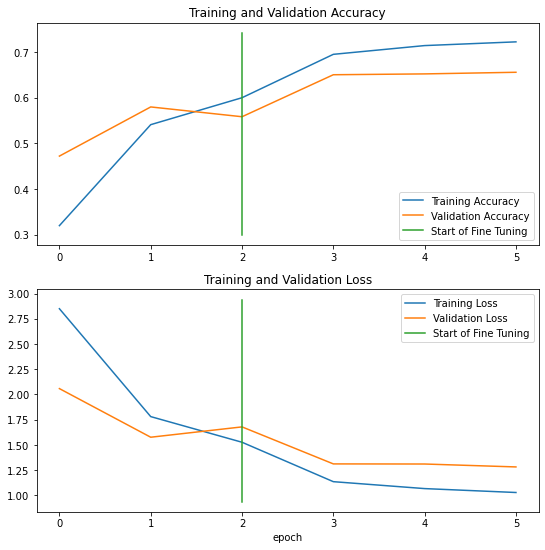

In [25]:
compare_histories(history, history_tuned, initial_epochs=3)

#### get prediction

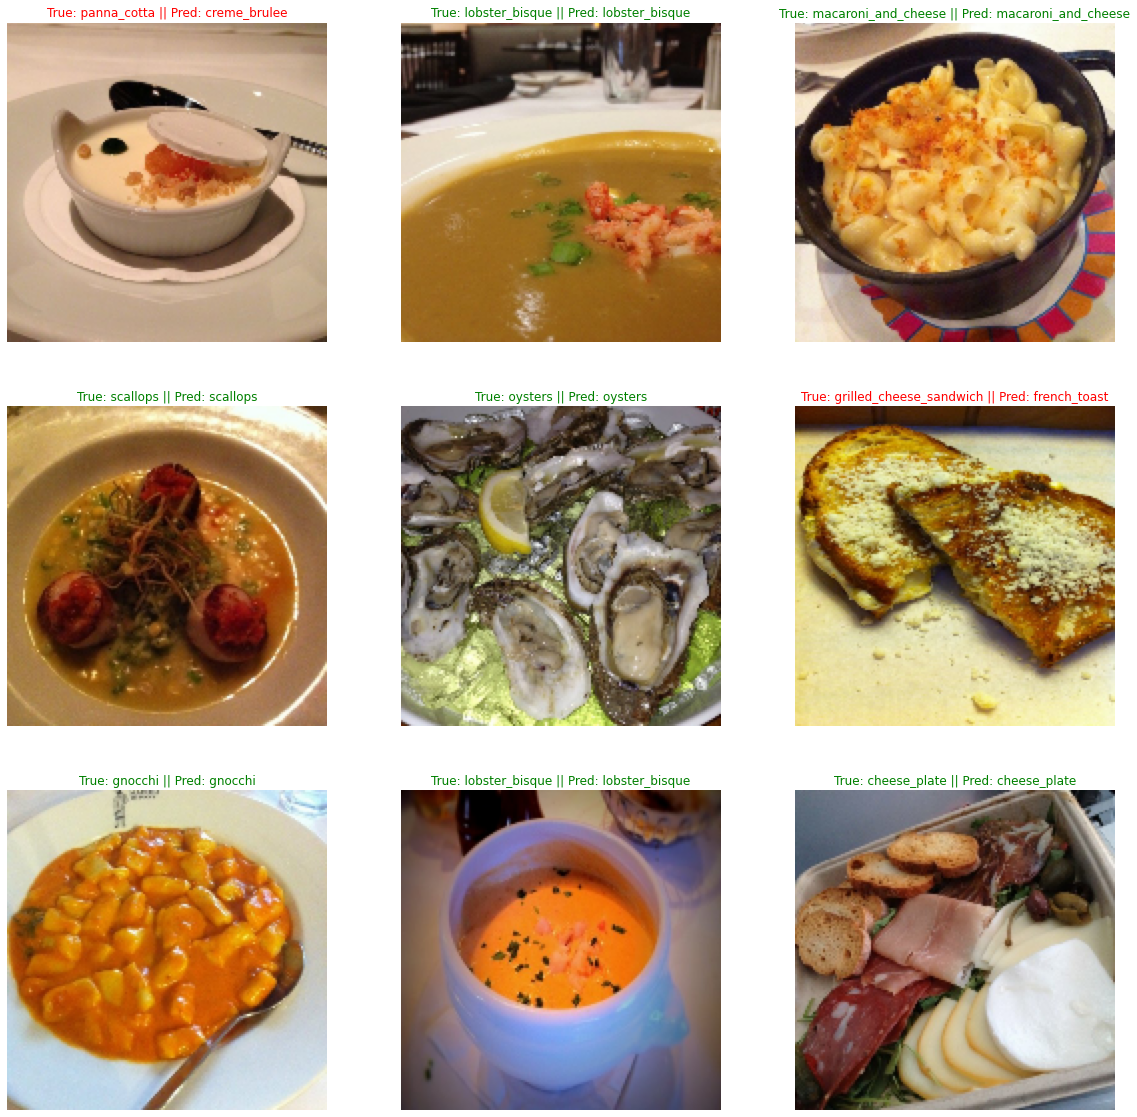

In [26]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

predictions = tf.argmax(predictions, axis=1)

# print('Predictions:\n', predictions)
# print('Labels:\n', label_batch)

plt.figure(figsize=(20, 20))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img = (image_batch[i]+1)*127
    img = img.astype(np.int32)
    
    plt.imshow(img)
    if label_batch[i] == predictions[i]:
        color = "g"
    else:
        color = "r"
    plt.title("True: " + class_names[label_batch[i]] + " || " + "Pred: " +
              class_names[predictions[i]], c=color)
    plt.axis("off")